In [1]:
import wandb
import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy import stats

TICKS_SIZE = 22
LABEL_SIZE = 14
LEGEND_SIZE = 14
TITLE_SIZE = 14

In [2]:
# Initialize the Weights and Biases API
api = wandb.Api(timeout=109)

# Specify the project details
entity = "teambolland"  # The username or organization name
project = "state-density-rl-cluster"  # The project name in your wandb dashboard

# Fetch all runs for the specified project
runs = api.runs(f"{entity}/{project}")

# Initialize a list to store loss data for learning curves
run_data = []

# Loop through each run and extract the loss history
for i, run in enumerate(runs):
    # Get the history of each run (all the logged metrics)
    history = run.scan_history()
    
    for j, row in enumerate(history):
        run_data.append({
            "run_id": run.id,
            "run_name": run.name,
            "alpha_infty": run.config.get("alpha_infty", None),
            "alpha_reward": run.config.get("alpha_reward", None),
            "env_name": run.config.get("env_name", None),
            "save_path": run.config.get("save_path", None),
            "density_plot_period": run.config.get("density_plot_period", None),
            "step": row.get("_step", None),  # Epoch or step, depending on the logging system
            "algo-it": row.get("algo-it", None),
            "joint-weighted-entropy-feature": row.get("joint-weighted-entropy-feature", None),
            "expected-return": row.get("expected return", None),
        })


# Convert the list of data to a pandas DataFrame
run_data = pd.DataFrame(run_data)

# Save the loss history with env_name to a CSV file
run_data.to_csv("wandb_maxentrl.csv", index=False)

In [3]:
def get_sta_curve(env, exp, field, pd_data):
    # only keep the data from the corresponding environment
    pd_data_ = pd_data[pd_data["env_name"] == env]

    # only keep the data from the corresponding experiment
    rg = f"^[^/]+/{env}-{exp}-\\d+"
    pd_data_ = pd_data_[pd_data_["save_path"].str.match(rg, na=False)]
    
    it_list = []
    data_list = []
    for run in pd_data_["run_name"].unique():
        if run == "genial-dust-31":
            continue
            
        filtered_data = pd_data_[pd_data_["run_name"] == run]
        
        # get the iterations
        it = filtered_data["step"].values
        data = filtered_data[field].values
        it_algo = filtered_data.get("algo-it", filtered_data["step"]).values
        
        # sort
        arg_it = np.argsort(it)
        
        # add to list            
        it_list.append(it_algo[arg_it])
        data_list.append(data[arg_it])
        
    iteration = np.stack(it_list, axis=0).mean(axis=0)
    data = np.stack(data_list, axis=0)
    
    # remove nan and curtail sequence
    nb_max = 2000
    
    iteration = iteration[~np.isnan(data).any(axis=0)][:nb_max]
    data = data[:, ~np.isnan(data).any(axis=0)][:, :nb_max]

    # filter the data
    data = uniform_filter1d(data, size=5)
    
    stat_bootstrap = stats.bootstrap((data,),
                                     statistic=lambda data, axis : stats.trim_mean(data, proportiontocut=0.25, axis=axis),
                                     vectorized=True,
                                     method="percentile",
                                     confidence_level=0.95,
                                     axis=0)
    
    data_med = np.mean(stat_bootstrap.bootstrap_distribution, axis=-1)
    data_max = stat_bootstrap.confidence_interval.high
    data_min = stat_bootstrap.confidence_interval.low
    

    return iteration, data_med, data_max, data_min

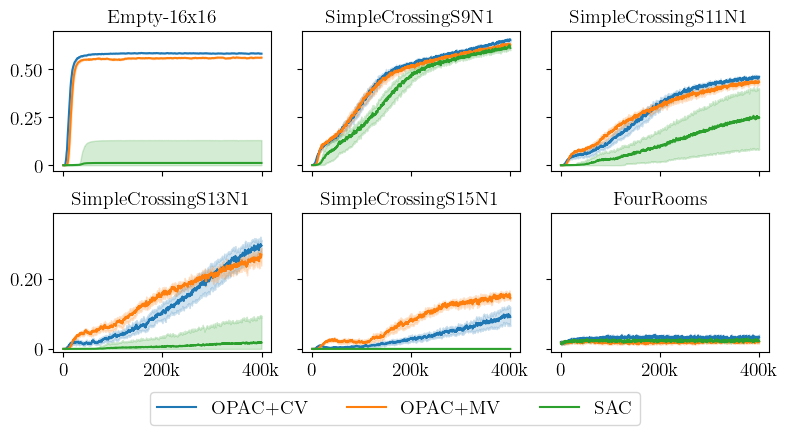

In [4]:
environments = ["Empty-16x16", "SimpleCrossingS9N1", "SimpleCrossingS11N1",
                "SimpleCrossingS13N1", "SimpleCrossingS15N1", "FourRooms"]

# tex
mpl.rc('font', family=['serif'], serif=['Computer Modern'])
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, axes = plt.subplots(2, 3, figsize=(8, 4))

run_data = pd.read_csv("wandb_maxentrl.csv")

for env_, (i, j) in zip(environments,
                        itertools.product(range(2), range(3))):
    
    env = f"MiniGrid-{env_}-v0"
    
    if i == 0:
        axes[i, j].xaxis.set_ticklabels([])
        axes[i, j].set_ylim(ymin=-0.03, ymax=0.7)
    else:
        axes[i, j].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x // 1000)}k' if x else f'{int(x)}'))
        axes[i, j].set_ylim(ymin=-0.01, ymax=0.39)
        
    if j != 0:
        axes[i, j].yaxis.set_ticklabels([])
    else:
        axes[i, j].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x:.2f}' if x else f'{int(x)}'))

    axes[i, j].set_title(env_, fontsize=TITLE_SIZE)
    
    axes[i, j].xaxis.set_tick_params(labelsize=LABEL_SIZE)
    axes[i, j].yaxis.set_tick_params(labelsize=LABEL_SIZE)
  
    iterations_1, med_1, min_1, max_1 = get_sta_curve(env, 3, "expected-return", run_data)
    iterations_2, med_2, min_2, max_2 = get_sta_curve(env, 4, "expected-return", run_data)
    iterations_3, med_3, min_3, max_3 = get_sta_curve(env, 5, "expected-return", run_data)
    
    line_1 = axes[i, j].plot(iterations_1, med_1)    
    line_2 = axes[i, j].plot(iterations_2, med_2)
    line_3 = axes[i, j].plot(iterations_3, med_3)
    
    axes[i, j].fill_between(iterations_1, min_1, max_1, alpha=.2, color=line_1[-1].get_color())
    axes[i, j].fill_between(iterations_2, min_2, max_2, alpha=.2, color=line_2[-1].get_color())
    axes[i, j].fill_between(iterations_3, min_3, max_3, alpha=.2, color=line_3[-1].get_color())

# legend
lgd = fig.legend(['OPAC+CV', 'OPAC+MV', 'SAC'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0.03), fontsize=LEGEND_SIZE)

plt.tight_layout()

plt.savefig('return_control.pdf', bbox_inches='tight')
plt.show()



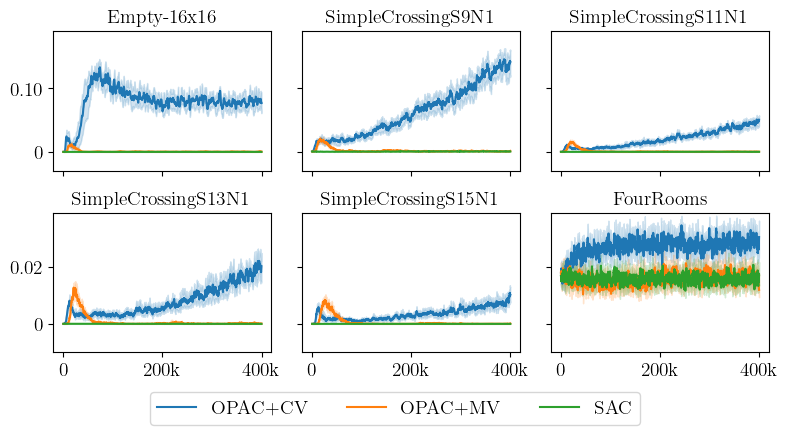

In [5]:
environments = ["Empty-16x16", "SimpleCrossingS9N1", "SimpleCrossingS11N1",
                "SimpleCrossingS13N1", "SimpleCrossingS15N1", "FourRooms"]

# tex
mpl.rc('font', family=['serif'], serif=['Computer Modern'])
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, axes = plt.subplots(2, 3, figsize=(8, 4))

# run_data = pd.read_csv("wandb_maxentrl.csv")

for env_, (i, j) in zip(environments,
                        itertools.product(range(2), range(3))):
    
    env = f"MiniGrid-{env_}-v0"
    
    if i == 0:
        axes[i, j].xaxis.set_ticklabels([])
        axes[i, j].set_ylim(ymin=-0.03, ymax=0.19)
    else:
        axes[i, j].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x // 1000)}k' if x else f'{int(x)}'))
        axes[i, j].set_ylim(ymin=-0.01, ymax=0.039)
        
    if j != 0:
        axes[i, j].yaxis.set_ticklabels([])
    else:
        axes[i, j].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x:.2f}' if x else f'{int(x)}'))

    axes[i, j].set_title(env_, fontsize=TITLE_SIZE)
    
    axes[i, j].xaxis.set_tick_params(labelsize=LABEL_SIZE)
    axes[i, j].yaxis.set_tick_params(labelsize=LABEL_SIZE)
  
    iterations_1, med_1, min_1, max_1 = get_sta_curve(env, 0, "expected-return", run_data)
    iterations_2, med_2, min_2, max_2 = get_sta_curve(env, 1, "expected-return", run_data)
    iterations_3, med_3, min_3, max_3 = get_sta_curve(env, 2, "expected-return", run_data)
    
    line_1 = axes[i, j].plot(iterations_1, med_1)    
    line_2 = axes[i, j].plot(iterations_2, med_2)
    line_3 = axes[i, j].plot(iterations_3, med_3)
    
    axes[i, j].fill_between(iterations_1, min_1, max_1, alpha=.2, color=line_1[-1].get_color())
    axes[i, j].fill_between(iterations_2, min_2, max_2, alpha=.2, color=line_2[-1].get_color())
    axes[i, j].fill_between(iterations_3, min_3, max_3, alpha=.2, color=line_3[-1].get_color())

# legend
lgd = fig.legend(['OPAC+CV', 'OPAC+MV', 'SAC'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0.03), fontsize=LEGEND_SIZE)

plt.tight_layout()

plt.savefig('return_exploration.pdf', bbox_inches='tight')
plt.show()

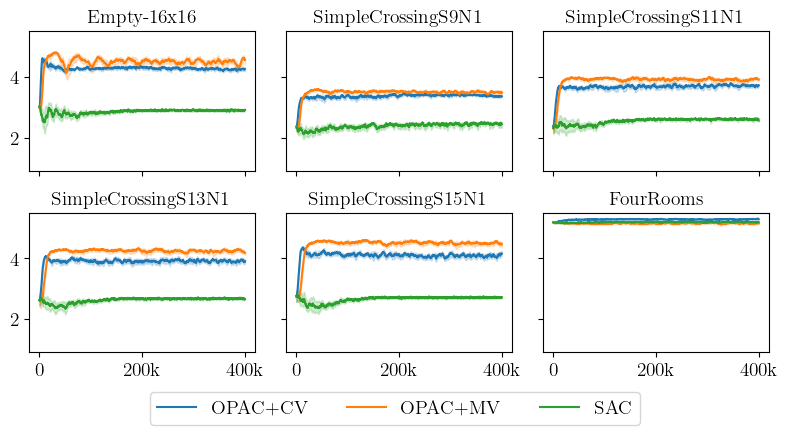

In [6]:
environments = ["Empty-16x16", "SimpleCrossingS9N1", "SimpleCrossingS11N1",
                "SimpleCrossingS13N1", "SimpleCrossingS15N1", "FourRooms"]

# tex
mpl.rc('font', family=['serif'], serif=['Computer Modern'])
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, axes = plt.subplots(2, 3, figsize=(8, 4))

# run_data = pd.read_csv("wandb_maxentrl.csv")


for env_, (i, j) in zip(environments,
                        itertools.product(range(2), range(3))):
    
    env = f"MiniGrid-{env_}-v0"
    
    if i == 0:
        axes[i, j].xaxis.set_ticklabels([])
        axes[i, j].set_ylim(ymin=0.9, ymax=5.5)
    else:
        axes[i, j].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x // 1000)}k' if x else f'{int(x)}'))
        axes[i, j].set_ylim(ymin=0.9, ymax=5.5)
        
    if j != 0:
        axes[i, j].yaxis.set_ticklabels([])

    axes[i, j].set_title(env_, fontsize=TITLE_SIZE)
    
    axes[i, j].xaxis.set_tick_params(labelsize=LABEL_SIZE)
    axes[i, j].yaxis.set_tick_params(labelsize=LABEL_SIZE)
    
    iterations_1, med_1, min_1, max_1 = get_sta_curve(env, 0, "joint-weighted-entropy-feature", run_data)
    iterations_2, med_2, min_2, max_2 = get_sta_curve(env, 1, "joint-weighted-entropy-feature", run_data)
    iterations_3, med_3, min_3, max_3 = get_sta_curve(env, 2, "joint-weighted-entropy-feature", run_data)
    
    line_1 = axes[i, j].plot(iterations_1, med_1)    
    line_2 = axes[i, j].plot(iterations_2, med_2)
    line_3 = axes[i, j].plot(iterations_3, med_3)
    
    axes[i, j].fill_between(iterations_1, min_1, max_1, alpha=.2, color=line_1[-1].get_color())
    axes[i, j].fill_between(iterations_2, min_2, max_2, alpha=.2, color=line_2[-1].get_color())
    axes[i, j].fill_between(iterations_3, min_3, max_3, alpha=.2, color=line_3[-1].get_color())

# legend
lgd = fig.legend(['OPAC+CV', 'OPAC+MV', 'SAC'], ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0.03), fontsize=LEGEND_SIZE)

plt.tight_layout()

plt.savefig('entropy_exploration.pdf', bbox_inches='tight')
plt.show()

